
# Data: Past, Present, Future
## Lab 10, Mar 28 2019
## Databases and recommendation engines


> Campaigns are moving away from the meaningless labels of pollsters and newsweeklies — “Nascar dads” and “waitress moms” — and moving toward treating each voter as a separate person. In 2012 you didn’t just have to be an African-American from Akron or a suburban married female age 45 to 54. More and more, the information age allows people to be complicated, contradictory and unique. New technologies and an abundance of data may rattle the senses, but they are also bringing a fresh appreciation of the value of the individual to American politics.

Ethan Roeder, [“I Am Not Big Brother”](http://www.nytimes.com/2012/12/06/opinion/i-am-not-big-brother.html)


## Privacy, and Databases in the 1970s and 1980s

In testimony before the US Congress in 1984, the privacy advocate Robert E. Smith presented a diagram illustrating how private databases from educational, retail, medical, and credit rating sectors intertwined with a dizzying array of state and federal databases. 


![privacy](https://i.imgur.com/jpqGNp2.jpg)

Combining commercial and government data could easily reveal startling parts of an individuals’ personal life. Ellis explained the potency of combining commercial household data and IRS data:
>Mr. GLICKMAN. […]  Is the IRS now renting computerized lists that provide demographic profiles of various households so they can find out if I go to the movies, or the Lion D'or for dinner, or Las Vegas for a weekend, and then determine if I am not paying enough in taxes?

>Mr. SMITH. Well, not quite that data, but they could indicate that you had a Cadillac and a Ford.

>Mr. GLICKMAN. But could they look into, let's say, my American Express account?

>Mr. SMITH. Not into it; the fact that you had such an account might be reflected, and the general balance that you keep, that might be in there, yes. 
 
The pullies in the diagram showed congress how hundreds of databases had come together by the mid 1980s, Smith argued, to make a “de facto” national database involving most residents of the United States.  




## connecting people and the long tail

>In 1988, a British mountain climber named Joe Simpson wrote a book called *Touching the Void*, a harrowing account of near death in the Peruvian Andes. It got good reviews but, only a modest success, it was soon forgotten. Then, a decade later, a strange thing happened. Jon Krakauer wrote *Into Thin Air*, another book about a mountain-climbing tragedy, which became a publishing sensation. Suddenly *Touching the Void* started to sell again. . .. 

> What happened? In short, Amazon.com recommendations. The online bookseller's software noted patterns in buying behavior and suggested that readers who liked *Into Thin Air* would also like *Touching the Void*. People took the suggestion, agreed wholeheartedly, wrote rhapsodic reviews. More sales, more algorithm-fueled recommendations, and the positive feedback loop kicked in.

Chris Anderson, [The Long Tail](https://www.wired.com/2004/10/tail/)
                
![long tail](https://media.wired.com/photos/5a59579a5451ae3d197fcf65/master/w_650,c_limit/FF_170_tail2_f.gif)

![long tail connection](https://media.wired.com/photos/5a5957cf2bbf59566d73366b/master/w_550,c_limit/FF_170_tail6_f.gif)



## Netflix prize

In 2009, BellKor's Pragmatic Chaos won the Netflix Prize for building a superior movie recommender system.

![winners](https://graphics8.nytimes.com/images/2009/09/21/technology/netflixawards.480.jpg)



![netflix prize](https://i.imgur.com/6TUm2Yj.png)



(see the cached version at https://web.archive.org/web/20070202023620/http://www.netflixprize.com:80/rules)


Netflix data set:

> 5-star ratings on 17770 movies and 480189 anonymous users over ~7 years. total of 100480507 ratings

A good deal of commerical data to use machine learning on, collected over time by the ordinary actions of users. Potentially telling us an awful lot about users


We'll try a smaller data set. We won't win a million dollars.


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

We'll be using the MovieLens data set with 100K ratings from http://grouplens.org/datasets/movielens/. For now, it's available to you locally. There you can find much bigger sets.

(Compare a great blog post using `pandas` on the same data: http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/.) The approach and tools are slightly different. Worth checking out!

You need to have a directory dat/ml-100k in the same place as this notebook.

We are going to look at three files: u.data, u.item, u.user


![relational](http://imgur.com/ZhpRFTj.png)

## relational database

>[The relational model] organizes data into one or more tables (or "relations") of columns and rows, with a unique key identifying each row. 

>each table/relation represents one "entity type" (such as customer or product). The rows represent instances of that type of entity (such as "Lee" or "chair") and the columns representing values attributed to that instance (such as address or price). (h/t wikipedia)

Created by E. F. Cobb at IBM around 1969, see https://dl.acm.org/citation.cfm?doid=362384.362685



In [5]:
films=pd.read_csv('./dat/ml-100k/u.item', 
                  sep="|", 
                  names=["movie id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action","Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"], index_col="movie id", encoding="latin1")

users=pd.read_csv('./dat/ml-100k/u.user', 
                  sep="|", 
                  names=["user_id", "age", "gender","occupation","zip_code"], index_col="user_id")

ratings=pd.read_csv( './dat/ml-100k/u.data', 
                    sep="\t", 
                    names=["user_id","item_id","rating","timestamp"]) #\t because TAB separated

In [6]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


What's with that crazy number? According to the `README`, it's "unix seconds." A quick google search explains how to convert using the `pd.to.datetime` command. I will remember this just long enough to type the next few lines.

It is said that 95% of data analysis is fussing or munging the data. This is 

In [7]:
ratings["timestamp"]=pd.to_datetime(ratings["timestamp"], unit='s')

In [8]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


Now, this is nice. 

What if we wanted to get all the items that one user ranked?


We could use "boolean indexing."

In [9]:
users.loc[42]

age                      30
gender                    M
occupation    administrator
zip_code              17870
Name: 42, dtype: object

In [10]:
films.loc[102]

movie_title                                      Aristocats, The (1970)
release_date                                                01-Jan-1970
video_release_date                                                  NaN
IMDb_URL              http://us.imdb.com/M/title-exact?Aristocats,%2...
unknown                                                               0
Action                                                                0
Adventure                                                             0
Animation                                                             1
Children's                                                            1
Comedy                                                                0
Crime                                                                 0
Documentary                                                           0
Drama                                                                 0
Fantasy                                                         

What did Mr. administrator # 42 rate?

In [11]:
ratings["user_id"]==42

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
99970    False
99971    False
99972    False
99973    False
99974    False
99975    False
99976    False
99977    False
99978    False
99979    False
99980    False
99981    False
99982    False
99983    False
99984    False
99985    False
99986    False
99987    False
99988    False
99989    False
99990    False
99991    False
99992    False
99993    False
99994    False
99995    False
99996    False
99997    False
99998    False
99999    False
Name: user_id, Length: 100000, dtype: bool

Once we're in the confort zone with boolean indexing, we'd probably condense all that into one line:

In [12]:
ratings[ratings["user_id"]==42]

,user_id,item_id,rating,timestamp
58,42,423,5,1997-12-03 00:08:07
87,42,403,3,1997-12-03 00:24:44
111,42,96,5,1997-12-02 23:59:38
166,42,794,3,1997-12-03 00:20:25
310,42,546,3,1997-12-02 23:36:57
638,42,274,5,1997-12-02 23:36:57
659,42,588,5,1997-12-03 00:15:47
754,42,44,3,1997-12-03 00:22:28
778,42,1028,4,1997-12-02 23:41:12
871,42,625,3,1997-12-03 00:27:53


How might we profile user 42 based on this data? Think of three ways and do one.

In [13]:
ratings[ratings["user_id"]==42]['rating']

58       5
87       3
111      5
166      3
310      3
638      5
659      5
754      3
778      4
871      3
1119     4
1245     2
1656     4
1761     3
1864     5
2179     4
2290     4
2394     4
2431     4
2613     4
2809     4
2833     3
2863     3
2979     3
3060     4
3162     3
3480     5
3542     4
3601     5
3824     5
        ..
59045    3
60647    3
61040    2
61695    3
62662    4
63521    4
67740    3
68778    5
69604    5
70257    1
70653    1
71380    3
73843    1
74673    3
76940    3
77201    5
79562    5
79923    4
82241    3
84817    5
85776    2
86538    4
86768    4
87394    4
88397    4
89527    4
93817    2
94791    4
97557    4
98433    3
Name: rating, Length: 183, dtype: int64

`pandas` lets us do all sorts of simple statistics, like finding the mean. just tack on the method `mean`.

In [14]:
ratings[ratings["user_id"]==42]['rating'].mean()

3.726775956284153

How about all the ratings for a given film, say no. 65? 

How would we get that? 

Same idea!

In [15]:
ratings[ratings["item_id"]==65]

,user_id,item_id,rating,timestamp
247,62,65,4,1997-11-12 22:44:46
1042,271,65,3,1998-01-26 21:16:59
1152,207,65,3,1997-10-29 05:56:34
2321,303,65,4,1997-11-14 00:30:36
2608,279,65,1,1997-09-26 20:46:07
3111,313,65,2,1998-03-27 16:42:42
7149,59,65,4,1998-02-23 03:41:05
9097,378,65,3,1997-11-20 17:15:32
9178,151,65,4,1997-11-14 17:32:09
10285,128,65,4,1997-11-19 19:41:52


How do we get the average rating for film 65?


In [16]:
ratings[ratings["item_id"]==65]["rating"].mean()


3.5391304347826087

And we might want to know something about there's a lot of variation in views about the film.

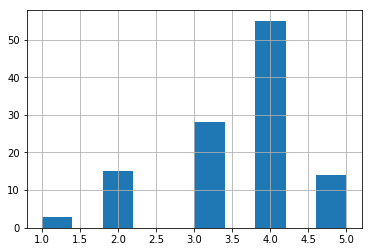

In [17]:
ratings[ratings["item_id"]==65]["rating"].hist()

# Pandas as a powerful database



## SPLIT-APPLY-COMBINE

> - Splitting the data into groups based on some criteria
> - Applying a function to each group independently
> - Combining the results into a data structure

check the docs!



![SPLIT](http://i.imgur.com/yjNkiwL.png)


In [18]:
users.groupby(by=["occupation", "gender"]).mean()

age
occupation    gender           
administrator F       40.638889
              M       37.162791
artist        F       30.307692
              M       32.333333
doctor        M       43.571429
educator      F       39.115385
              M       43.101449
engineer      F       29.500000
              M       36.600000
entertainment F       31.000000
              M       29.000000
executive     F       44.000000
              M       38.172414
healthcare    F       39.818182
              M       45.400000
homemaker     F       34.166667
              M       23.000000
lawyer        F       39.500000
              M       36.200000
librarian     F       40.000000
              M       40.000000
marketing     F       37.200000
              M       37.875000
none          F       36.500000
              M       18.600000
other         F       35.472222
              M       34.028986
programmer    F       32.166667
              M       33.216667
retired       F       70.000000
              M       62.538462
salesman      F       27.000000
              M       38.555556
scientist     F       28.333333
              M       36.321429
student       F       20.750000
              M       22.669118
technician    F       38.000000
              M       32.961538
writer        F       37.631579
              M       35.346154

# Pivot


What if we wanted to have a big table where each row is the user followed by all her ratings?
We could write a few lines of code to produce this.

Fortunately, Pandas will do this heavy lifting for us using the `pivot` method.


In [19]:
ratings=ratings.pivot(index="user_id", columns="item_id", values="rating")

Basically: rework our data using user_id as row names; item_id as column names and all the ratings as the values

In [20]:
ratings[100:115]

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
101,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,3.0,2.0,NaN,2.0,3.0,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,4.0,NaN,NaN,2.0,3.0,NaN,4.0,3.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Question: Why all the NaNs?


#### Another question to the user: Why not switch all the NaNs to zeros?


This is called a *sparse* matrix: most of the values are empty. 

Most large scale commerical rating or purchasing data looks like this. Why?




### Question: What did we lose from our original dataframe?

### Question: What questions could no longer ask?

- say we wanted to know whether people rate movies differently at different times of the day? or differently during different seasons?.



We can now easily ask about the mean ratings of each user, and the mean ratings of each movie? 

How would we do these operations differently?

In [21]:
ratings.mean(axis=0)

item_id
1       3.878319
2       3.206107
3       3.033333
4       3.550239
5       3.302326
6       3.576923
7       3.798469
8       3.995434
9       3.896321
10      3.831461
11      3.847458
12      4.385768
13      3.418478
14      3.967213
15      3.778157
16      3.205128
17      3.119565
18      2.800000
19      3.956522
20      3.416667
21      2.761905
22      4.151515
23      4.120879
24      3.448276
25      3.443686
26      3.452055
27      3.105263
28      3.931159
29      2.666667
30      3.945946
          ...   
1653    5.000000
1654    1.000000
1655    2.000000
1656    3.500000
1657    3.000000
1658    3.000000
1659    1.000000
1660    2.000000
1661    1.000000
1662    2.500000
1663    2.000000
1664    3.250000
1665    2.000000
1666    2.000000
1667    3.000000
1668    3.000000
1669    2.000000
1670    3.000000
1671    1.000000
1672    2.000000
1673    3.000000
1674    4.000000
1675    3.000000
1676    2.000000
1677    3.000000
1678    1.000000
1679    3.000000
1680  

Which movies are not garbage according to the masses?

In [22]:
ratings.mean(0)>4.25

item_id
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12       True
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
        ...  
1653     True
1654    False
1655    False
1656    False
1657    False
1658    False
1659    False
1660    False
1661    False
1662    False
1663    False
1664    False
1665    False
1666    False
1667    False
1668    False
1669    False
1670    False
1671    False
1672    False
1673    False
1674    False
1675    False
1676    False
1677    False
1678    False
1679    False
1680    False
1681    False
1682    False
Length: 1682, dtype: bool

In [23]:
the_good_stuff=ratings.mean(0)>4.25

And where would we find the names of these films?

In [24]:
films[the_good_stuff]

,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
12,"Usual Suspects, The (1995)",14-Aug-1995,NaN,http://us.imdb.com/M/title-exact?Usual%20Suspe...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
64,"Shawshank Redemption, The (1994)",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Shawshank%20R...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,"Silence of the Lambs, The (1991)",01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Silence%20of%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
114,Wallace & Gromit: The Best of Aardman Animatio...,05-Apr-1996,NaN,http://us.imdb.com/Title?Wallace+%26+Gromit%3A...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
119,Maya Lin: A Strong Clear Vision (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,NaN,"http://us.imdb.com/M/title-exact?Godfather,%20...",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134,Citizen Kane (1941),01-Jan-1941,NaN,http://us.imdb.com/M/title-exact?Citizen%20Kan...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
169,"Wrong Trousers, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Wrong%20Trous...,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


How find the bad stuff?

Cool!
What are the average ratings per user?

We need to use `mean` across columns.

In [25]:
ratings.mean(1) #average rating per user axis 1 is rows--user ids

user_id
1      3.610294
2      3.709677
3      2.796296
4      4.333333
5      2.874286
6      3.635071
7      3.965261
8      3.796610
9      4.272727
10     4.206522
11     3.464088
12     4.392157
13     3.097484
14     4.091837
15     2.875000
16     4.328571
17     3.035714
18     3.880866
19     3.550000
20     3.104167
21     2.670391
22     3.351562
23     3.635762
24     4.323529
25     4.051282
26     2.943925
27     3.240000
28     3.721519
29     3.647059
30     3.767442
         ...   
914    3.086957
915    3.115385
916    3.365931
917    3.542857
918    3.349515
919    3.470046
920    3.230769
921    3.272727
922    3.370079
923    4.148649
924    3.756098
925    3.125000
926    3.300000
927    3.691667
928    4.687500
929    3.693878
930    2.968254
931    3.721311
932    3.966805
933    2.646739
934    3.701149
935    3.923077
936    3.746479
937    3.375000
938    3.268519
939    4.265306
940    3.457944
941    4.045455
942    4.265823
943    3.410714
Length: 943, dty

In [26]:
ratings.mean(1)>4 # axis 1 is rows--user ids

user_id
1      False
2      False
3      False
4       True
5      False
6      False
7      False
8      False
9       True
10      True
11     False
12      True
13     False
14      True
15     False
16      True
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24      True
25      True
26     False
27     False
28     False
29     False
30     False
       ...  
914    False
915    False
916    False
917    False
918    False
919    False
920    False
921    False
922    False
923     True
924    False
925    False
926    False
927    False
928     True
929    False
930    False
931    False
932    False
933    False
934    False
935    False
936    False
937    False
938    False
939     True
940    False
941     True
942     True
943    False
Length: 943, dtype: bool

In [27]:
those_lacking_discernment=ratings.mean(1)>4
pretentious_movie_snobs=ratings.mean(1)<2.5

What are some of things we might want to do with our knowledge of the users and their rating?

In [28]:
users[those_lacking_discernment].head(15)

,age,gender,occupation,zip_code
user_id,,,,
4,24,M,technician,43537
9,29,M,student,01002
10,53,M,lawyer,90703
12,28,F,other,06405
14,45,M,scientist,55106
16,21,M,entertainment,10309
24,21,F,artist,94533
25,39,M,engineer,55107
34,38,F,administrator,42141


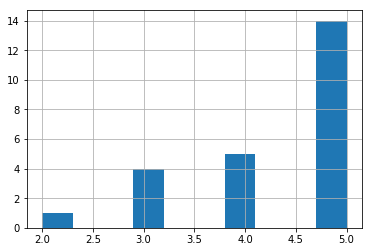

In [29]:
ratings.loc[4].hist()

In [30]:
users[pretentious_movie_snobs]

,age,gender,occupation,zip_code
user_id,,,,
181,26,M,executive,21218
206,14,F,student,53115
302,42,M,educator,77904
405,22,F,healthcare,10019
445,21,M,writer,92653
609,13,F,student,55106
626,23,M,scientist,19807
637,30,M,other,74101
685,32,F,librarian,55409


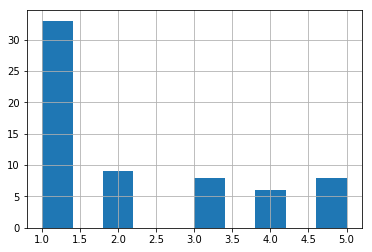

In [31]:
ratings.loc[206].hist()

What does the teenager from Delavan, WI not hate? Could you figure it out? 

And, if we were Netflix, what would we want to recommed to her?

## What might we want to do with our new knowledge

Let's discount the less discerning viewers! Let's just lower their rankings by .75. A bit arbitrary, but so are they!

We could multiply every element in a dataframe by a constant like so:


In [32]:
ratings[those_lacking_discernment]*.75

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,3.75,3.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,3.00,NaN,NaN,3.00,NaN,NaN,3.00,NaN,3.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,3.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,3.75,NaN,3.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,3.75,NaN,NaN,3.75,NaN,NaN,3.75,3.75,3.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,NaN,NaN,NaN,NaN,3.00,3.75,3.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,3.75,NaN,NaN,NaN,NaN,NaN,3.00,3.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## Recommending stuff

Lots of strategies.
Any ideas?


- Find most similar *users*

- Find most similar *items*

Use data from users to recommend items: called *collaborative filtering*.

Combine them!

Users understood as row of ratings of films--a vector.

Films understood as row of ratings of films--a vector.

How determine what is *similar* and what is *different*?

Lots of choices in determining similarity.

We'll use *cosine similarity*.

![cosine](http://i0.wp.com/techinpink.com/wp-content/uploads/2017/07/cosine.png)

In [33]:
from scipy.spatial.distance import cosine  #cosine distance function--not cosine similarity

In [34]:
def cosine_similarity(A,B):
    return 1 - cosine(A,B)

In [35]:
cosine_similarity((1,0),(0,1))

0.0

In [36]:
cosine_similarity((1,2),(3,4))

0.98386991009990743

In [37]:
cosine_similarity([1,1,0],[0,1,2])


0.316227766016838

In [38]:
import numpy as np

In [39]:
np.array([np.mean(ratings, 1)]).T

array([[ 3.61029412],
       [ 3.70967742],
       [ 2.7962963 ],
       [ 4.33333333],
       [ 2.87428571],
       [ 3.63507109],
       [ 3.96526055],
       [ 3.79661017],
       [ 4.27272727],
       [ 4.20652174],
       [ 3.4640884 ],
       [ 4.39215686],
       [ 3.09748428],
       [ 4.09183673],
       [ 2.875     ],
       [ 4.32857143],
       [ 3.03571429],
       [ 3.88086643],
       [ 3.55      ],
       [ 3.10416667],
       [ 2.67039106],
       [ 3.3515625 ],
       [ 3.63576159],
       [ 4.32352941],
       [ 4.05128205],
       [ 2.94392523],
       [ 3.24      ],
       [ 3.72151899],
       [ 3.64705882],
       [ 3.76744186],
       [ 3.91666667],
       [ 3.31707317],
       [ 3.70833333],
       [ 4.05      ],
       [ 3.        ],
       [ 3.8       ],
       [ 3.64912281],
       [ 3.71900826],
       [ 3.77272727],
       [ 2.88571429],
       [ 3.76923077],
       [ 3.72677596],
       [ 3.71040724],
       [ 3.64900662],
       [ 3.60416667],
       [ 4

In [40]:

ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Those NaNs are trouble. 

One way to normalize is to subtract each users' mean rating for his or her row.

In [41]:
ratings.mean(axis=1).head()

user_id
1    3.610294
2    3.709677
3    2.796296
4    4.333333
5    2.874286
dtype: float64

In [42]:
ratings.fillna(0).sub(pd.Series(ratings.mean(axis=1)), 0)

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,-0.610294,0.389706,-0.610294,-0.610294,1.389706,0.389706,-2.610294,1.389706,-0.610294,...,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294,-3.610294
2,0.290323,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-1.709677,...,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677,-3.709677
3,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,...,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296,-2.796296
4,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,...,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333,-4.333333
5,1.125714,0.125714,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,...,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286,-2.874286
6,0.364929,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-1.635071,0.364929,0.364929,-3.635071,...,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071,-3.635071
7,-3.965261,-3.965261,-3.965261,1.034739,-3.965261,-3.965261,1.034739,1.034739,1.034739,0.034739,...,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261,-3.965261
8,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-0.796610,-3.796610,-3.796610,-3.796610,...,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610,-3.796610
9,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,0.727273,-0.272727,-4.272727,-4.272727,-4.272727,...,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727,-4.272727


In [43]:
ratings_normalized=ratings.fillna(0).sub(pd.Series(ratings.mean(axis=1)), 0)

Now can compare users to users and movies to movies!

In [44]:
cosine_similarity(ratings_normalized.loc[24], ratings_normalized.loc[25])

0.96571797267383952

To compute the similarities, we'll pick one film (#1) and compute the cosine similarity with every other film. What's number one?

In [45]:
films.loc[1]

movie_title                                            Toy Story (1995)
release_date                                                01-Jan-1995
video_release_date                                                  NaN
IMDb_URL              http://us.imdb.com/M/title-exact?Toy%20Story%2...
unknown                                                               0
Action                                                                0
Adventure                                                             0
Animation                                                             1
Children's                                                            1
Comedy                                                                1
Crime                                                                 0
Documentary                                                           0
Drama                                                                 0
Fantasy                                                         

In [46]:
def find_similarities(film):
    similarities={}
    for i in range(1,944):
         similarities[i]=cosine_similarity(ratings_normalized.loc[film], ratings_normalized.loc[i])
    return pd.Series(similarities)

# probably would be better to do in a vectorized way with dot product

In [47]:
find_similarities(1)

1      1.000000
2      0.895873
3      0.886239
4      0.899358
5      0.891535
6      0.895616
7      0.849317
8      0.910412
9      0.900710
10     0.894035
11     0.882633
12     0.911329
13     0.756729
14     0.905147
15     0.882790
16     0.906533
17     0.907214
18     0.890525
19     0.902868
20     0.905412
21     0.858502
22     0.903770
23     0.910536
24     0.906039
25     0.909373
26     0.893169
27     0.902716
28     0.905522
29     0.900467
30     0.902024
         ...   
914    0.898722
915    0.897491
916    0.901885
917    0.900775
918    0.891413
919    0.877593
920    0.898310
921    0.895003
922    0.905690
923    0.892254
924    0.905094
925    0.897560
926    0.901491
927    0.890268
928    0.907963
929    0.908665
930    0.905787
931    0.894448
932    0.874815
933    0.909228
934    0.893977
935    0.898495
936    0.887484
937    0.903025
938    0.884943
939    0.895506
940    0.900871
941    0.904521
942    0.892999
943    0.898494
Length: 943, dtype: floa

So what are the most similar films according to this crazy way of proceeding?

In [48]:
find_similarities(1).sort_values(ascending=False).head()

1      1.000000
738    0.923078
521    0.918669
215    0.918039
77     0.917536
dtype: float64

In [49]:
films['movie_title'][find_similarities(1).sort_values(ascending=False).head().index]

1             Toy Story (1995)
738           Threesome (1994)
521    Deer Hunter, The (1978)
215     Field of Dreams (1989)
77            Firm, The (1993)
Name: movie_title, dtype: object

In [50]:
def most_similar(film, number=5):
    most=films['movie_title'][find_similarities(film).sort_values(ascending=False).head(number).index]
    print(most)

In [51]:
most_similar(3)

3                     Four Rooms (1995)
317    In the Name of the Father (1993)
335           How to Be a Player (1997)
920                     Two Bits (1995)
143          Sound of Music, The (1965)
Name: movie_title, dtype: object


In [52]:
most_similar(143)

143                        Sound of Music, The (1965)
356                                Client, The (1994)
809                                 Rising Sun (1993)
166    Manon of the Spring (Manon des sources) (1986)
820                                  Space Jam (1996)
Name: movie_title, dtype: object


Not the most promising approach!!

# So what really do?

For a good survey of recommending engines at scale, see the chapter from the [Stanford mining massive data course](http://infolab.stanford.edu/~ullman/mmds/ch9.pdf)


Major problem: too high a dimensional space to use lots of algorithms efficiently!

Trick: reduce dimensionality using aspects of films and users!

Version of *principal component analysis* called SVD.

SVD decomposes a large matrix into three components:

![SVD diagram](http://xieyan87.com/wp-content/uploads/2015/06/SVD.png)


Allows you to generate *latent factors* and then calculate similarities. 

![latent factor](https://image.slidesharecdn.com/petroniphdthesispresentation-161104150721/95/mining-at-scale-with-latent-factor-models-for-matrix-completion-8-638.jpg?cb=1478272108)

Serious vs. escapist
geared-male vs. geared-female
&c.



In [53]:
A = ratings_normalized.values.T / np.sqrt(len(films) - 1)
U, S, V = np.linalg.svd(A)

# modified from numpy focused https://alyssaq.github.io/2015/20150426-simple-movie-recommender-using-svd/

Chose how many factors to consider.

In [54]:
k=25
pd.DataFrame(V.T[:, :k])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.029424,0.064055,0.009547,-0.044855,0.044055,-0.050149,-0.065167,0.053146,-0.062578,0.031499,...,0.018079,-0.027622,0.065486,-0.041948,0.046599,-0.000286,0.082962,-0.034512,0.027576,-0.055873
1,-0.034153,-0.026904,0.002407,-0.047102,-0.021614,0.028639,-0.004650,0.021551,-0.017190,0.033951,...,-0.007143,0.024093,0.012322,0.018696,-0.010792,0.001254,-0.005228,0.011356,-0.002014,-0.041748
2,-0.025779,-0.025556,0.000646,0.000922,0.029219,0.042775,0.000013,0.007494,0.004495,-0.025363,...,0.010560,-0.014584,-0.008424,-0.026904,0.006970,0.004846,-0.016532,0.005793,0.000984,-0.016334
3,-0.040653,-0.033415,-0.000807,0.022025,0.018169,0.008021,-0.005485,-0.005953,0.004401,-0.015410,...,0.029722,-0.023214,-0.017383,-0.008348,0.012572,-0.010351,-0.000552,0.020499,0.018079,0.005299
4,-0.024770,0.026937,0.018769,0.048485,0.018430,-0.051662,-0.035461,0.094959,0.039609,0.009428,...,-0.004641,0.034625,0.003646,0.021750,0.011275,0.011786,-0.047335,-0.015708,0.005289,-0.004587
5,-0.030784,0.045619,-0.091016,-0.052869,-0.020305,-0.001829,0.044925,0.023223,-0.009548,-0.032735,...,0.002988,0.014864,0.078842,0.011293,-0.029704,0.002839,0.048559,0.021735,0.000109,-0.009251
6,-0.029449,0.102175,-0.057031,0.045925,0.026437,0.026599,0.077087,-0.014902,0.150347,0.049656,...,0.079779,0.065236,0.017961,0.051237,-0.019106,-0.148739,-0.080493,-0.023516,0.089329,-0.066521
7,-0.035049,0.002850,0.011736,0.036573,0.051711,-0.018936,0.030336,-0.001407,-0.075580,0.058541,...,0.019610,-0.007840,-0.062780,-0.018683,-0.012721,-0.034319,0.015463,0.075047,0.020187,-0.021104
8,-0.040124,-0.027815,-0.013115,0.019529,-0.000282,-0.018251,-0.004812,-0.013427,0.013485,0.008633,...,-0.001694,-0.006947,0.015016,0.005214,0.022280,0.010308,0.014374,0.010297,-0.007165,0.021119
9,-0.036134,0.042547,-0.085529,-0.038119,0.016143,-0.001971,0.034384,-0.041673,0.038431,-0.006488,...,0.052064,0.005607,0.062453,0.023708,0.002725,-0.043553,0.046357,0.070920,0.004852,0.023679


In [55]:
def find_similarities(film, sliced):
    similarities={}
    for i in range(1,944):
         similarities[i]=cosine_similarity(sliced[film-1], sliced[i-1])
    return pd.Series(similarities)

def most_similar(film, sliced, number=5):
    most=films['movie_title'][find_similarities(film, sliced).sort_values(ascending=False).head(number).index]
    print(most)

In [56]:
k = 50
movie_id = 1 # Grab an id from movies.dat
top_n = 10

sliced = V.T[:, :k] # representative data


In [57]:
find_similarities(1,sliced)


1      1.000000
2      0.162501
3     -0.048132
4      0.083834
5      0.120170
6      0.189425
7     -0.087849
8      0.016610
9     -0.228456
10     0.018306
11    -0.068993
12     0.114163
13    -0.083365
14    -0.161193
15     0.030033
16     0.017622
17    -0.014638
18     0.180079
19     0.003606
20     0.039054
21    -0.025405
22    -0.015110
23    -0.091397
24    -0.073328
25     0.024418
26     0.063551
27    -0.186293
28     0.083063
29     0.143254
30     0.000682
         ...   
914    0.085691
915   -0.075398
916    0.157384
917    0.095165
918   -0.082196
919    0.070849
920   -0.077759
921    0.171102
922    0.045111
923   -0.174053
924   -0.163068
925   -0.075032
926   -0.050968
927   -0.024264
928    0.224665
929    0.089789
930    0.053627
931   -0.130403
932    0.067586
933    0.239400
934    0.088482
935   -0.200162
936    0.096337
937    0.031134
938   -0.146294
939   -0.123475
940   -0.196015
941   -0.053517
942   -0.086320
943   -0.031938
Length: 943, dtype: floa

In [58]:
most_similar(405, sliced)

405                Mission: Impossible (1996)
712                            Tin Men (1987)
642                      Grifters, The (1990)
846    To Gillian on Her 37th Birthday (1996)
686                   Perfect World, A (1993)
Name: movie_title, dtype: object


# Back to Netflix challenge

![winners](https://graphics8.nytimes.com/images/2009/09/21/technology/netflixawards.480.jpg)

Very close--came down to which group submitted first!

![leaderboard](https://cdn0.tnwcdn.com/wp-content/blogs.dir/1/files/2012/04/NFlix-520x285.png)

## Social ensemble of teams competing.

![venn](https://i1.wp.com/s3-ap-northeast-1.amazonaws.com/wpstoragepublicshare/netflix/bellkor_team.png)

## Algorithmic ensemble 

![bellkordiagram](https://i.imgur.com/cHXxYIl.jpg)



# **Huge** victory of predictive machine learning values!

# But meanwhile...

![dumpster_fire](https://media1.tenor.com/images/2b68afa54bb22fbe90f9201dfaaa2af0/tenor.gif?itemid=7182596)



[FAQ](https://web.archive.org/web/20070202024240/https://www.netflixprize.com/faq) for Netflix Challenge reads:

>“Is there any customer information in the dataset that should be kept private?” 
    
>“No, all customer identifying information has been removed; all that remains are ratings and dates. This follows our privacy policy [. . . ] Even if, for example, you knew all your own ratings and their dates you probably couldn’t identify them reliably in the data because only a small sample was included (less than one tenth of our complete dataset) and that data was subject to perturbation. Of course, since you know all your own ratings that really isn’t a privacy problem is it?”

# Sorry, nope. Not so much.


Arvind Narayanan and Vitaly Shmatikov then of UT Austin

showed 

>an adversary who knows only a little bit about
an individual subscriber can easily identify this subscriber’s
record in the [Netflix] dataset. Using the Internet
Movie Database as the source of background knowledge,
we successfully identified the Netflix records of
known users, uncovering their apparent political preferences
and other potentially sensitive information.


[Robust De-anonymization of Large Datasets](https://www.cs.utexas.edu/~shmat/shmat_oak08netflix.pdf)



# How does all this lead to more

![dumpster_fire](https://media1.tenor.com/images/2b68afa54bb22fbe90f9201dfaaa2af0/tenor.gif?itemid=7182596)

glory of recommender engines:

> long tail
- connect people who may have never known one another
- connect people with things they might never have known

disaster of recommender enginers:

> put like with like: filter bubble

Political twitter according to ["Political Polarization on Twitter"](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM11/paper/download/2847/3275)

![polarization](http://themonkeycage.org/wp-content/uploads/2011/07/Screen-shot-2011-07-27-at-11.23.29-AM.png)

political retweet (left) and mention (right) networks, laid out using a force-directed algorithm.
